In [8]:
#NOTE: The input labels must be sequential (e.g., [1,2,3], not [1,3,4]). You can use skimage.segmentation.relabel_sequential to ensure compliance.
#Maybe do a forward map and then an inverse map to get back to original labels?
#This is more modular


In [2]:
import os
import numpy as np
import pandas as pd
from skimage import filters, morphology, measure
import skimage
import matplotlib.pyplot as plt
from cp_measure.bulk import get_core_measurements
from skimage.measure import label, regionprops, regionprops_table
import scripts.cpda as cpda
import scipy.ndimage as nd
from functools import partial

In [6]:
def curvature(this_mask):
    try:
        outline = (skimage.morphology.dilation(this_mask) ^ this_mask)*1.0
        curves = skimage.measure.find_contours(outline, 0.0, fully_connected='high')
        # Smooth contour with Gaussian kernel
        sigma = 3.0

        smoothedCurves={}
        for c in range(0, len(curves)):
            sx = nd.gaussian_filter1d(curves[c][:,0], sigma)
            sy = nd.gaussian_filter1d(curves[c][:,1], sigma)

            smoothedCurves[c] = np.vstack((sx,sy))
        objectSizes=[len(smoothedCurves[c][0]) for c in smoothedCurves]
        ind=np.where(objectSizes==np.max(objectSizes))[0][0]

        # Input parameters for CPDA
    #    Lvals=[10,25,50,75,100,200,400,800,1000]
        Lvals=[10]
        # Compute CPDA
        for L in Lvals:
            # If indexing runs clockwise, flip it:
            curve=np.flip(smoothedCurves[ind],axis=1)
            # Else, no need to do anything:
            # curve=smoothedCurves[ind]
            H_L=cpda.cpda(curve, L) # This computes curvature

        mean = np.mean(H_L)
        std = np.std(H_L)
        mymin = np.min(H_L)
        mymax = np.max(H_L)
        frac_below_zero = np.sum(H_L < 0)/len(H_L)
        

        return mean, std, mymin, mymax, frac_below_zero
    except:
        return -1.0, -1.0, -1.0, -1.0, -1.0

In [48]:
def calculate_cpmeasure(pixels, masks):
    """
    Calculate cell morphology measurements using cp_measure.

    Parameters:
    - pixels: 2D numpy array representing the image pixels.
    - masks: 2D numpy array representing the labeled masks.

    Returns:
    - results: DataFrame containing the morphology measurements for each labeled region.
    """

    masks, fw, inv = skimage.segmentation.relabel_sequential(masks)
    print(fw)
    print(inv)
    measurements = get_core_measurements()

    results = {}
    for name, v in measurements.items():
        results = {**results, **v(masks, pixels)}

    df_results = pd.DataFrame(results)
    df_results.index = df_results.index + 1
    df_results.index = df_results.index.map(inv)
    return df_results

In [53]:
measurements = get_core_measurements()
measurements.keys()

dict_keys(['radial_distribution', 'radial_zernikes', 'intensity', 'sizeshape', 'zernike', 'ferret', 'texture', 'granularity'])

ArrayMap:
  0 → 0
  1 → 1
  ...
  5 → 5
  12 → 6
ArrayMap:
  0 → 0
  1 → 1
  ...
  5 → 5
  6 → 12


,RadialDistribution_FracAtD_1of4,RadialDistribution_MeanFrac_1of4,RadialDistribution_RadialCV_1of4,RadialDistribution_FracAtD_2of4,RadialDistribution_MeanFrac_2of4,RadialDistribution_RadialCV_2of4,RadialDistribution_FracAtD_3of4,RadialDistribution_MeanFrac_3of4,RadialDistribution_RadialCV_3of4,RadialDistribution_FracAtD_4of4,...,Granularity_7,Granularity_8,Granularity_9,Granularity_10,Granularity_11,Granularity_12,Granularity_13,Granularity_14,Granularity_15,Granularity_16
1,0.521053,10.205742,0.603154,0.026316,0.147095,0.677855,0.336842,1.054578,0.637274,0.115789,...,4.763180,6.208311,8.034223,9.334919,11.538987,12.956806,14.071576,15.509617,21.007048,21.957951
2,0.162921,2.842372,0.762452,0.069288,0.383905,0.427970,0.475655,1.483174,0.540277,0.292135,...,3.844671,4.447949,5.471530,7.081640,7.081640,7.681442,8.645927,8.975850,11.578887,12.396425
3,0.334385,6.867274,0.682016,0.173502,0.974244,0.424721,0.334385,1.044599,0.748161,0.157729,...,4.447039,4.891546,5.283725,7.122239,8.549163,10.541848,12.268392,15.026023,15.506260,15.506260
4,0.180225,3.232964,0.772919,0.317897,1.744322,0.506523,0.315394,0.992577,0.601046,0.186483,...,3.516697,4.232371,5.843253,7.729606,9.575118,10.784720,11.202173,12.065038,12.506339,12.506339
5,0.268428,4.858349,0.647787,0.228095,1.254785,0.559822,0.260083,0.813533,0.714280,0.243394,...,3.747965,4.866587,5.638853,6.305707,7.063199,8.579319,9.365508,11.354421,13.242468,16.440073
12,0.465721,9.400665,0.652149,0.390071,2.180396,0.649868,0.111111,0.347023,0.315729,0.033097,...,4.152948,5.598650,7.009823,8.868972,9.936665,11.095832,14.123537,15.064622,18.643893,19.733698


,label,curvature-0,curvature-1,curvature-2,curvature-3,curvature-4
label,,,,,,
1,1,-7.291891,4.237722,-17.729188,-2.609475,1.0
2,2,-6.109680,3.847623,-14.664564,-2.752097,1.0
3,3,-6.169725,4.229899,-17.115150,-2.715414,1.0
4,4,-6.056101,4.205841,-17.376438,-1.892059,1.0
5,5,-5.932920,4.573463,-19.176969,-0.007927,1.0
12,12,-5.820387,4.314944,-17.795300,-1.667513,1.0


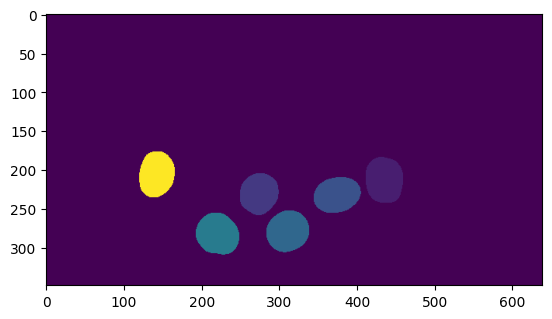

In [36]:



# path to the image
pixels_path = "1_data/fieldofview1/fov1_T=000.tif"
masks_path = "3c_tracking_images_filtered/fieldofview1/fov1_T=000.tif"

# read image (handles multi-page / multi-channel TIFFs)
pixels = skimage.io.imread(pixels_path)
masks = skimage.io.imread(masks_path)

masks[masks==6] = 12
df = calculate_cpmeasure(pixels, masks)
df2 = pd.DataFrame(regionprops_table(masks, properties = ('label',), extra_properties=[curvature]))
df2.index = df2['label']
display(df)
display(df2)

plt.imshow(masks)




In [39]:
help(pd.merge)

Help on function merge in module pandas.core.reshape.merge:

merge(left: 'DataFrame | Series', right: 'DataFrame | Series', how: 'MergeHow' = 'inner', on: 'IndexLabel | AnyArrayLike | None' = None, left_on: 'IndexLabel | AnyArrayLike | None' = None, right_on: 'IndexLabel | AnyArrayLike | None' = None, left_index: 'bool' = False, right_index: 'bool' = False, sort: 'bool' = False, suffixes: 'Suffixes' = ('_x', '_y'), copy: 'bool | None' = None, indicator: 'str | bool' = False, validate: 'str | None' = None) -> 'DataFrame'
    Merge DataFrame or named Series objects with a database-style join.
    
    A named Series object is treated as a DataFrame with a single named column.
    
    The join is done on columns or indexes. If joining columns on
    columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
    on indexes or indexes on a column or columns, the index will be passed on.
    When performing a cross merge, no column specifications to merge on are
    allo

In [54]:
for i in range(len(df.columns)):
    print(df.columns[i])

RadialDistribution_FracAtD_1of4
RadialDistribution_MeanFrac_1of4
RadialDistribution_RadialCV_1of4
RadialDistribution_FracAtD_2of4
RadialDistribution_MeanFrac_2of4
RadialDistribution_RadialCV_2of4
RadialDistribution_FracAtD_3of4
RadialDistribution_MeanFrac_3of4
RadialDistribution_RadialCV_3of4
RadialDistribution_FracAtD_4of4
RadialDistribution_MeanFrac_4of4
RadialDistribution_RadialCV_4of4
RadialDistribution_ZernikeMagnitude_0_0
RadialDistribution_ZernikePhase_0_0
RadialDistribution_ZernikeMagnitude_1_1
RadialDistribution_ZernikePhase_1_1
RadialDistribution_ZernikeMagnitude_2_0
RadialDistribution_ZernikePhase_2_0
RadialDistribution_ZernikeMagnitude_2_2
RadialDistribution_ZernikePhase_2_2
RadialDistribution_ZernikeMagnitude_3_1
RadialDistribution_ZernikePhase_3_1
RadialDistribution_ZernikeMagnitude_3_3
RadialDistribution_ZernikePhase_3_3
RadialDistribution_ZernikeMagnitude_4_0
RadialDistribution_ZernikePhase_4_0
RadialDistribution_ZernikeMagnitude_4_2
RadialDistribution_ZernikePhase_4_2


In [38]:
pd.merge(df2, df, left_index=True, right_index=True)

,label,curvature-0,curvature-1,curvature-2,curvature-3,curvature-4,RadialDistribution_FracAtD_1of4,RadialDistribution_MeanFrac_1of4,RadialDistribution_RadialCV_1of4,RadialDistribution_FracAtD_2of4,...,Granularity_7,Granularity_8,Granularity_9,Granularity_10,Granularity_11,Granularity_12,Granularity_13,Granularity_14,Granularity_15,Granularity_16
label,,,,,,,,,,,,,,,,,,,,,
1,1,-7.291891,4.237722,-17.729188,-2.609475,1.0,0.521053,10.205742,0.603154,0.026316,...,4.763180,6.208311,8.034223,9.334919,11.538987,12.956806,14.071576,15.509617,21.007048,21.957951
2,2,-6.109680,3.847623,-14.664564,-2.752097,1.0,0.162921,2.842372,0.762452,0.069288,...,3.844671,4.447949,5.471530,7.081640,7.081640,7.681442,8.645927,8.975850,11.578887,12.396425
3,3,-6.169725,4.229899,-17.115150,-2.715414,1.0,0.334385,6.867274,0.682016,0.173502,...,4.447039,4.891546,5.283725,7.122239,8.549163,10.541848,12.268392,15.026023,15.506260,15.506260
4,4,-6.056101,4.205841,-17.376438,-1.892059,1.0,0.180225,3.232964,0.772919,0.317897,...,3.516697,4.232371,5.843253,7.729606,9.575118,10.784720,11.202173,12.065038,12.506339,12.506339
5,5,-5.932920,4.573463,-19.176969,-0.007927,1.0,0.268428,4.858349,0.647787,0.228095,...,3.747965,4.866587,5.638853,6.305707,7.063199,8.579319,9.365508,11.354421,13.242468,16.440073
12,12,-5.820387,4.314944,-17.795300,-1.667513,1.0,0.465721,9.400665,0.652149,0.390071,...,4.152948,5.598650,7.009823,8.868972,9.936665,11.095832,14.123537,15.064622,18.643893,19.733698


In [32]:
df2

,label,area,curvature-0,curvature-1,curvature-2,curvature-3,curvature-4
0,1,2370.0,-7.291891,4.237722,-17.729188,-2.609475,1.0
1,2,2111.0,-6.109680,3.847623,-14.664564,-2.752097,1.0
2,3,2218.0,-6.169725,4.229899,-17.115150,-2.715414,1.0
3,4,2332.0,-6.056101,4.205841,-17.376438,-1.892059,1.0
4,5,2371.0,-5.932920,4.573463,-19.176969,-0.007927,1.0
5,12,2180.0,-5.820387,4.314944,-17.795300,-1.667513,1.0


In [28]:
df2

,curvature-0,curvature-1,curvature-2,curvature-3,curvature-4
0,-7.291891,4.237722,-17.729188,-2.609475,1.0
1,-6.109680,3.847623,-14.664564,-2.752097,1.0
2,-6.169725,4.229899,-17.115150,-2.715414,1.0
3,-6.056101,4.205841,-17.376438,-1.892059,1.0
4,-5.932920,4.573463,-19.176969,-0.007927,1.0
5,-5.820387,4.314944,-17.795300,-1.667513,1.0


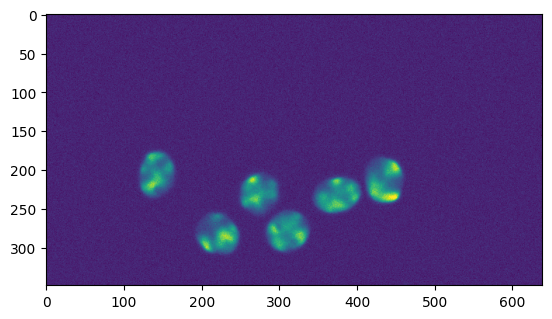

In [11]:
plt.imshow(pixels)

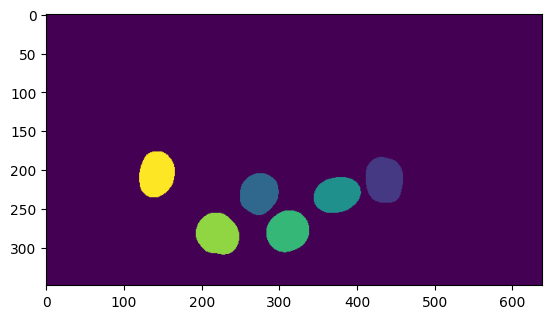

In [12]:
plt.imshow(masks)

In [13]:
# Get measurements
measurements = get_core_measurements()

results = {}
for name, v in measurements.items():
    results = {**results, **v(masks, pixels)}

In [ ]:
results

In [20]:
help(get_core_measurements)

Help on function get_core_measurements in module cp_measure.bulk:

get_core_measurements() -> dict[str, typing.Callable]



In [19]:
print(results)

{'RadialDistribution_FracAtD_1of4': array([0.52105263, 0.16292135, 0.33438486, 0.18022528, 0.26842837,
       0.46572104]), 'RadialDistribution_MeanFrac_1of4': array([10.20574163,  2.84237162,  6.86727421,  3.23296428,  4.85834864,
        9.40066544]), 'RadialDistribution_RadialCV_1of4': array([0.60315441, 0.76245163, 0.68201589, 0.77291887, 0.64778723,
       0.65214923]), 'RadialDistribution_FracAtD_2of4': array([0.02631579, 0.06928839, 0.17350158, 0.31789737, 0.22809458,
       0.39007092]), 'RadialDistribution_MeanFrac_2of4': array([0.14709533, 0.38390496, 0.9742443 , 1.74432158, 1.25478478,
       2.18039644]), 'RadialDistribution_RadialCV_2of4': array([0.67785468, 0.42797   , 0.4247208 , 0.50652285, 0.55982243,
       0.6498679 ]), 'RadialDistribution_FracAtD_3of4': array([0.33684211, 0.47565543, 0.33438486, 0.31539424, 0.26008345,
       0.11111111]), 'RadialDistribution_MeanFrac_3of4': array([1.05457832, 1.48317373, 1.04459946, 0.99257675, 0.81353279,
       0.34702324]), 'Rad